# Data exploration

## Selecting the data

We start by uploading the data and all necessary libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor

app_data = pd.read_csv('googleplaystore.csv')

Function below consumes a data frame and returns percentage/number of missing values for each feature(column). It will be used to have a better understanding of the data

In [2]:
def missing_values(test):
    total = test.isnull().sum().sort_values(ascending=False)
    percent_1 = test.isnull().sum() / test.isnull().count() * 100
    percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    
    return missing_data.head((missing_data['Total'] >= 0).sum())

Display the amount of missing values per column and what percentage of the column contains missing values

In [3]:
missing_values(app_data)

,Total,%
Rating,1474,13.6
Current Ver,8,0.1
Android Ver,3,0.0
Content Rating,1,0.0
Type,1,0.0
Last Updated,0,0.0
Genres,0,0.0
Price,0,0.0
Installs,0,0.0
Size,0,0.0


In [4]:
app_data.dropna(inplace = True)

In [5]:
missing_values(app_data)

,Total,%
Android Ver,0,0.0
Current Ver,0,0.0
Last Updated,0,0.0
Genres,0,0.0
Content Rating,0,0.0
Price,0,0.0
Type,0,0.0
Installs,0,0.0
Size,0,0.0
Reviews,0,0.0


In [6]:
app_data.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

We remove features that aren't useful for our modeling (last updated, current ver, and android ver).

In [7]:
not_useful = ['Last Updated', 'Current Ver', 'Android Ver']
app_data = app_data.drop(not_useful, axis = 1)
app_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity


## Converting the data into workable shape

In [8]:
app_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   object 
 4   Size            9360 non-null   object 
 5   Installs        9360 non-null   object 
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   object 
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
dtypes: float64(1), object(9)
memory usage: 475.3+ KB


We first convert Reviews to numeric form

In [9]:
app_data = app_data.astype({'Reviews': 'int32'})

Now, we convert Installs to numeric, removing the '+' at the end of each value.

In [10]:
app_data['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '100+', '500+', '10+',
       '5+', '50+', '1+'], dtype=object)

In [11]:
app_data['Installs'] = app_data['Installs'].replace('[\,]', '', regex = True).replace('[\+]', '', regex = True).astype(int)

In [12]:
app_data['Installs'].unique()

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,        100,        500,
               10,          5,         50,          1])

We will be starting by using LabelEncoding on "Type" column. As there are only 2 categories and no Nan values as they were removed with when we removed rows with many missing values earlier. 

In [13]:
# Change price column to free = 0 and paid = 1
# creating instance of labelencoder
paid_types = app_data["Type"].unique()
labelencoder = LabelEncoder()
app_data['Type'] = labelencoder.fit_transform(app_data['Type'])

Now, we deal with the "Price" column. Note that here, the data is already mostly numerical, so we will only remove the dollar sign

In [14]:
before = app_data["Price"].nunique()
app_data["Price"] = app_data["Price"].replace('[\$,]', '', regex=True).astype(float)
after = app_data["Price"].nunique()
f"Unique values before: {before}, unique values after: {after}"

'Unique values before: 73, unique values after: 73'

Then, "Content Rating". First, check all categories in this column

In [15]:
app_data["Content Rating"].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

First, as we can't assign a specific order to "Unrated", we will see how many rows have that value. If there are very few, we will use SimpleImputer to change change the value to the most common one

In [16]:
app_data[(app_data["Content Rating"] == "Unrated")]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
8266,DC Universe Online Map,TOOLS,4.1,1186,6.4M,50000,0,0.0,Unrated,Tools


In [17]:
imp_const = SimpleImputer(missing_values="Unrated", strategy = "most_frequent")
imp_const.fit(pd.DataFrame(app_data["Content Rating"]))
app_data["Content Rating"] = imp_const.transform(pd.DataFrame(app_data["Content Rating"]))

In [18]:
app_data["Content Rating"].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+'], dtype=object)

As the values in the "Content Rating" column can be ordered, we will be assigning a numerical value to each category. however, we will not be using LabelEncoder as is encodes in alphabetical order. Instead, we will create the an array of values we would like to replace and an array that we will replace with. Then, we iterate through both sets and replace on by one. 

In [19]:
unique_cr = np.array(['Everyone', 'Everyone 10+', 'Teen', 'Mature 17+', 'Adults only 18+'])
n = np.array([0, 10, 13, 17, 18])
for i,j in zip(unique_cr, n):
    app_data["Content Rating"] = app_data["Content Rating"].replace([i,], j)
unq = app_data["Content Rating"].unique()
f"Unique values in converted \"Content Rating\": {unq}"

'Unique values in converted "Content Rating": [ 0 13 10 17 18]'

Then, we work with "Size"

In [20]:
app_data["Size"].unique()[1:30]

array(['14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M', '28M',
       '12M', '20M', '21M', '37M', '5.5M', '17M', '39M', '31M', '4.2M',
       '23M', '6.0M', '6.1M', '4.6M', '9.2M', '5.2M', '11M', '24M',
       'Varies with device', '9.4M', '15M'], dtype=object)

Note that here, I am only showing the first 30 values because it would not look pretty to display all of them. I have looked at the full array and there are 3 types of values: "...M", "...k", and "Varies with device". I am assuming that M are megabytes and k are kilobytes. Hence, we will have to divide values with k by 1024 to have all values in the same units. Also, we will replace "Varies with device" by Nan so we can convert cells with numerical data propertly

In [21]:
def clean_size(size):
    if size[-1:] == "M":
        clean_size = float(size[:-1])
    elif size[-1:] == "k":
        clean_size = float(size[:-1]) / 1000
    else:
        clean_size = None
    return clean_size

app_data["Size"] = app_data["Size"].map(clean_size)

In [22]:
app_data["Size"].unique()[0:30]

array([19. , 14. ,  8.7, 25. ,  2.8,  5.6, 29. , 33. ,  3.1, 28. , 12. ,
       20. , 21. , 37. ,  5.5, 17. , 39. , 31. ,  4.2, 23. ,  6. ,  6.1,
        4.6,  9.2,  5.2, 11. , 24. ,  nan,  9.4, 15. ])

Then, we replace Nan values with mean and we add an extra column that will have 1 if the the original value in "Size" was "Varies with device" and 0 if it was an assigned value

In [23]:

#app_data["Size: Varies with device"] = (pd.get_dummies(app_data["Size"]))["nan"]
imp_size = SimpleImputer(missing_values= np.nan ,strategy = "mean")
imp_size.fit(pd.DataFrame(app_data["Size"]))
app_data["Size"] = (imp_size.transform(pd.DataFrame(app_data["Size"])))
app_data["Size"].unique()[0:30]

array([19.        , 14.        ,  8.7       , 25.        ,  2.8       ,
        5.6       , 29.        , 33.        ,  3.1       , 28.        ,
       12.        , 20.        , 21.        , 37.        ,  5.5       ,
       17.        , 39.        , 31.        ,  4.2       , 23.        ,
        6.        ,  6.1       ,  4.6       ,  9.2       ,  5.2       ,
       11.        , 24.        , 22.97045611,  9.4       , 15.        ])

In [24]:
app_data.dtypes

App                object
Category           object
Rating            float64
Reviews             int32
Size              float64
Installs            int32
Type                int32
Price             float64
Content Rating      int64
Genres             object
dtype: object

Now, we will work with Category. As there are 33 categories, using onehot encoder would create a lot of extra columns. Hence, we will use labelencoder. As the data not ordered naurally, we will assign the highest value to the most common category and lowest to the least common

In [25]:
app_data["Category"].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'],
      dtype=object)

In [26]:
n = app_data["Category"].unique()
c = []
for i in n:
    c.append([app_data[(app_data["Category"] == i)]["Category"].count(), i])
c.sort()

r = range(33)

for i,j in zip(c, r):
    app_data["Category"] = (app_data["Category"].replace(i[1], j, regex=True))

app_data["Category"] = app_data["Category"].astype("int")

Finally, we will look at "Genres" and decide what we should do with that column as it has many values similar to Category

In [27]:
app_data["Genres"].unique()[0:30]

array(['Art & Design', 'Art & Design;Pretend Play',
       'Art & Design;Creativity', 'Auto & Vehicles', 'Beauty',
       'Books & Reference', 'Business', 'Comics', 'Comics;Creativity',
       'Communication', 'Dating', 'Education;Education', 'Education',
       'Education;Creativity', 'Education;Music & Video',
       'Education;Action & Adventure', 'Education;Pretend Play',
       'Education;Brain Games', 'Entertainment',
       'Entertainment;Music & Video', 'Entertainment;Brain Games',
       'Entertainment;Creativity', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Lifestyle;Pretend Play'], dtype=object)

In [28]:
app_data[["Genre1", "Genre2"]] = app_data["Genres"].str.split(";", expand = True)
app_data = app_data.drop(["Genres"], axis=1)

In [29]:
app_data["Genre2"].unique()

array([None, 'Pretend Play', 'Creativity', 'Education', 'Music & Video',
       'Action & Adventure', 'Brain Games'], dtype=object)

We see that many values in the Genres column are the same as in Category. Since we might get 2 highly correlated columns, we should only keep one of them. We will be keeping Category as the data there is better organised.

In [30]:
app_data = app_data.drop(["Genre1", "Genre2"], axis=1)

## Data visualisation

We will see the trends in Category by first seeing how many apps there are in each category

<AxesSubplot:xlabel='Content Rating', ylabel='Rating'>

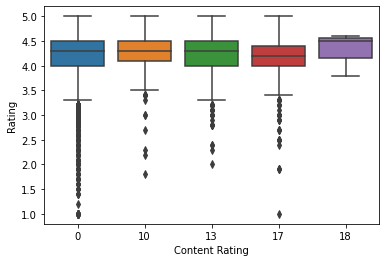

In [31]:
sns.boxplot(data=app_data, x="Content Rating", y="Rating")

We make a boxplot and see that category doesnt have that much of an effect on rating

<AxesSubplot:xlabel='Category', ylabel='Rating'>

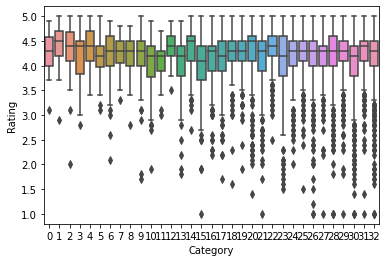

In [32]:
sns.boxplot(data=app_data, x="Category", y="Rating")

We look at Size under 20mb because most apps in the data set are under 20mb and it looks nicer

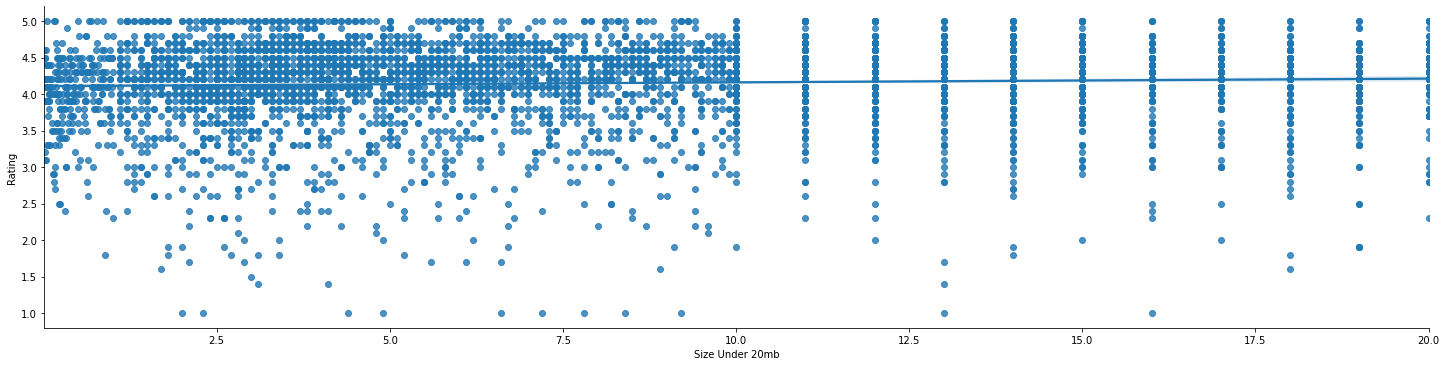

In [33]:
size_plot = pd.concat([app_data["Rating"], app_data["Size"][app_data["Size"] <= 20]], axis=1, keys=['Rating', 'Size Under 20mb'])
sns.lmplot(data=size_plot, x="Size Under 20mb", y="Rating", height=5, aspect=4)

We will also have a look at the correlation heatmap 

<AxesSubplot:>

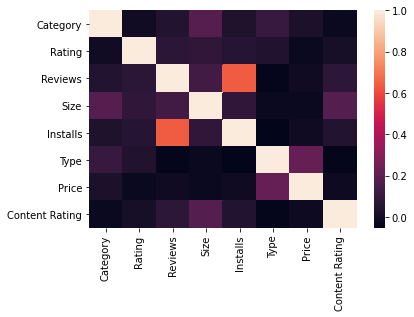

In [34]:
sns.heatmap(app_data.corr())

In [35]:
app_data.corr()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
Category,1.000000,-0.007037,0.045329,0.184310,0.029861,0.100108,0.022466,-0.022064
Rating,-0.007037,1.000000,0.068133,0.080305,0.051337,0.039592,-0.021919,0.011873
Reviews,0.045329,0.068133,1.000000,0.129407,0.641605,-0.043244,-0.009824,0.071113
Size,0.184310,0.080305,0.129407,1.000000,0.081223,-0.026517,-0.026257,0.177653
Installs,0.029861,0.051337,0.641605,0.081223,1.000000,-0.053049,-0.011895,0.045138
Type,0.100108,0.039592,-0.043244,-0.026517,-0.053049,1.000000,0.223344,-0.044661
Price,0.022466,-0.021919,-0.009824,-0.026257,-0.011895,0.223344,1.000000,-0.016300
Content Rating,-0.022064,0.011873,0.071113,0.177653,0.045138,-0.044661,-0.016300,1.000000


And, from the heatmap above, we can see that there is barely any correlation in the dataset. Great!

## Setup for models

First, we define the data we will predict- 'Rating', and the data we will use to predit it- Category, Size, Type, Price, and Content Rating.

In [36]:
predict = "Rating"

X = np.array(app_data.drop(["App", predict], axis = 1))
y = np.array(app_data[predict])

We choose to use %90 of the data to train the models and %10 to test them.

In [37]:
# set up the train and test variables and choose to use %10 of the data for testing
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.10)

## Linear Regression Model

Now, we create the linear regression model and give it the train data.
We also determine the accuracy of our models results by giving it the test data

In [38]:
model = linear_model.LinearRegression()

model.fit(x_train, y_train)
accuracy = model.score(x_test, y_test)
result = model.predict(x_test)

We see that the accuracy of our model is around 1%. Amazing!

In [39]:
accuracy

0.0021337358388234806

## Random Forest Regressor Model

In [40]:
model = RandomForestRegressor(n_estimators = 10)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10)

In [41]:
model.score(x_test, y_test)

-0.0037862243415345276